<a href="https://colab.research.google.com/github/Shaguftha29/Dst/blob/main/Oill_Spill_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Cell 1: Check GPU and basic imports
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

TensorFlow version: 2.19.0
GPU Available: []


In [ ]:
# Cell 2: Install libraries
!pip install opencv-python-headless scikit-image albumentations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Cell 4: Unzip dataset from Drive
import zipfile
import os
 # Path to your uploaded zip (adjust if different)
zip_path = '/content/drive/MyDrive/OillSpillProject/oill_spill_dataset.zip'
extract_path = '/content/oill_spill_dataset'  # Local temp extract

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 zip_ref.extractall(extract_path)

# Verify structure
!ls -la {extract_path}/train  # Should show images/ and masks/
print("Dataset extracted successfully!")

total 80
drwxr-xr-x 4 root root  4096 Sep 29 10:53 .
drwxr-xr-x 5 root root  4096 Sep 29 10:53 ..
drwxr-xr-x 2 root root 36864 Sep 29 10:53 images
drwxr-xr-x 2 root root 36864 Sep 29 10:53 masks
Dataset extracted successfully!


In [10]:
# Cell 5: Preprocessing functions
import albumentations as A
from sklearn.model_selection import train_test_split

IMG_SIZE = 256
BATCH_SIZE = 8  # Adjust if GPU memory issues

def load_and_preprocess_image(image_path, mask_path=None):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=-1)  # (H, W, 1)

    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = (mask > 127).astype(np.float32)  # Binary threshold
        mask = np.expand_dims(mask, axis=-1)
        return image, mask
    return image

# Augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
])

# Set paths (adjust to your extracted dataset)
dataset_base = '/content/oill_spill_dataset'  # Or '/content/drive/MyDrive/OilSpillProject/oill_spill_dataset' for persistent
train_img_dir = f'{dataset_base}/train/images'
train_mask_dir = f'{dataset_base}/train/masks'
val_img_dir = f'{dataset_base}/val/images'
val_mask_dir = f'{dataset_base}/val/masks'

# Get file lists (ensure paired by name)
train_images = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)
                       if f.endswith(('.png', '.jpg', '.jpeg'))])
train_masks = sorted([os.path.join(train_mask_dir, f.replace('.jpg', '.png'))  # Adjust extension if needed
                      for f in [os.path.basename(p) for p in train_images]])

val_images = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)
                     if f.endswith(('.png', '.jpg', '.jpeg'))]) if os.path.exists(val_img_dir) else []
val_masks = sorted([os.path.join(val_mask_dir, f.replace('.jpg', '.png'))
                    for f in [os.path.basename(p) for p in val_images]]) if len(val_images) > 0 else []

# Auto-split if no val data
if len(val_images) == 0:
    # Assume train has all; split
    temp_train_images = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)
                                if f.endswith(('.png', '.jpg', '.jpeg'))])
    temp_train_masks = sorted([os.path.join(train_mask_dir, f.replace('.jpg', '.png'))
                               for f in [os.path.basename(p) for p in temp_train_images]])
    train_images, val_images, train_masks, val_masks = train_test_split(
        temp_train_images, temp_train_masks, test_size=0.2, random_state=42
    )

print(f"Train samples: {len(train_images)}, Val samples: {len(val_images)}")
print("Sample paths:", train_images[:2])  # Verify paths

Train samples: 811, Val samples: 203
Sample paths: ['/content/oill_spill_dataset/train/images/Oil (1).jpg', '/content/oill_spill_dataset/train/images/Oil (10).jpg']


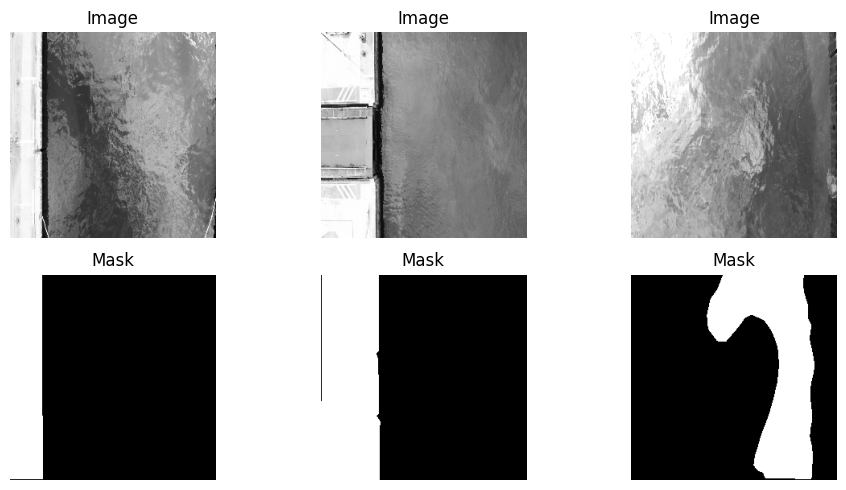

In [15]:
# Cell 6: Custom Data Generator
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

class OilSpillGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y = [], []

        for i in indexes:
            img_path = self.image_paths[i]
            mask_path = self.mask_paths[i]
            image, mask = load_and_preprocess_image(img_path, mask_path)

            if self.augment:
                augmented = augmentation(image=image, mask=mask)
                image, mask = augmented['image'], augmented['mask']

            batch_x.append(image)
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.augment:
            np.random.shuffle(self.indexes)

# Create generators
train_gen = OilSpillGenerator(train_images, train_masks, BATCH_SIZE, augment=True)
val_gen = OilSpillGenerator(val_images, val_masks, BATCH_SIZE, augment=False)

# Test generator (visualize one batch)
images, masks = train_gen[0]
plt.figure(figsize=(10, 5))
for i in range(3):  # Show first 3
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(2, 3, i+4)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')
plt.tight_layout()
plt.show()